In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from textblob import TextBlob
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# import re
# from collections import defaultdict, Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

stopwords=set(stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/6ones/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/6ones/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/6ones/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Style & Themes

sns.set_theme(style='darkgrid', context="notebook");

# Google Colors -> https://www.schemecolor.com/google-logo-colors.php
blue = '#4285F4'
red = '#EA4335'
yellow = '#FBBC05'
green = '#34A853'

In [5]:
# Helper methods

def load_data(file_location):
    df = pd.read_csv(file_location, index_col=False)
    return df


def clean_data(df):
    df = df.drop(['id_str'], axis=1)
    df = df.drop_duplicates()
    df = df.set_index('id')
    return df


def drop_cols(df, cols):
    """Drop columns"""
    df = df.drop(cols, axis='columns')
    return df


def to_datetime(df, cols):
    """Convert date columns to pandas datetime"""
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

&nbsp;
# Load tweets - Livongo 
Using __Livongo__ as a use case

In [6]:
df = load_data('./data/livongo.csv')

columns_to_drop = ['user_id_str','in_reply_to_status_id_str','in_reply_to_user_id_str','in_reply_to_screen_name','user_description']
date_columns = ['user_created_at','created_at']

df = (df
      .pipe(clean_data)
      .pipe(drop_cols, columns_to_drop)
      .pipe(to_datetime, date_columns))

&nbsp;
# Analysis on Tweets

## 1. Sentiment Analysis

Sentiment analysis is achieved using [Google Natural Language](https://cloud.google.com/natural-language).     

It provides 2 values for a text, which are `magnitude` and `score`. The score determines the sentiment, while the magnitude determines the "magnitude" of the sentiment.   
Read up on [interpreting sentiment values](https://cloud.google.com/natural-language/docs/basics#interpreting_sentiment_analysis_values) for deeper understanding.

### 1.1 Determine sentiment based on score & magnitude

In [7]:
def determine_sentiment(row):
    score, magnitude = row['score'], row['magnitude']
    if (score < -0.3 and magnitude >= 0.5):
        return 'negative'
    if (score < -0.5):
        return 'negative'
    if (score >= 0.3):
        return 'positive'
    return 'neutral'


def categorize_sentiment_score(df):
    """Categorize the sentiment score"""
    # df['sentiment'] = pd.cut(df.score, 3,labels=['negative','neutral','positive'])
    df['sentiment'] = df.apply(lambda row: determine_sentiment(row), axis=1)
    return df
 
df = df.pipe(categorize_sentiment_score)

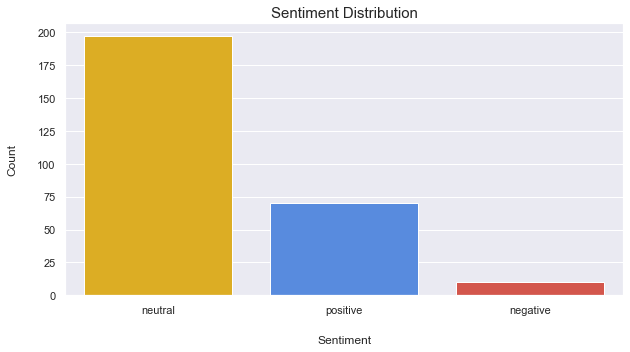

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

sns.countplot(x='sentiment', 
              data=df,
              ax=ax,
              palette=[yellow, blue, red],
              order = df['sentiment'].value_counts().index)

plt.title('Sentiment Distribution', fontsize=15);
plt.xlabel('Sentiment', labelpad=20)
plt.ylabel('Count', labelpad=20);

The chart above shows the distribution of tweets.  
We have a huge number of them as "Neutral" followed by "Positive" followed by "Negative"

&nbsp;
### 1.2 Chart of sentiment analysis across time
This puts the sentiment analysis in the context of the tweets.

In [9]:
def chart_sentiment(sentiment, ax = None):
    """Chart the sentiment"""
    try:
        chart = df.loc[df.sentiment == sentiment]
        hourly_sample = chart.set_index('created_at').resample('H').sum()
        hourly_sample.favorite_count.plot(ax=ax, label="Likes", color=blue)
        hourly_sample.retweet_count.plot(ax=ax, label="Retweets", color=green)
        ax.legend()
        ax.set_title(f'{sentiment.upper()} sentiment')
        ax.set_xlabel('Date')
        ax.set_ylabel('Count')
    except KeyError as e:
        print(f'{sentiment} is not a sentiment. Use either "positive", "neutral", "negative"')
    except:
        e = sys.exc_info()[0]
        print('Unknown error: ', e)

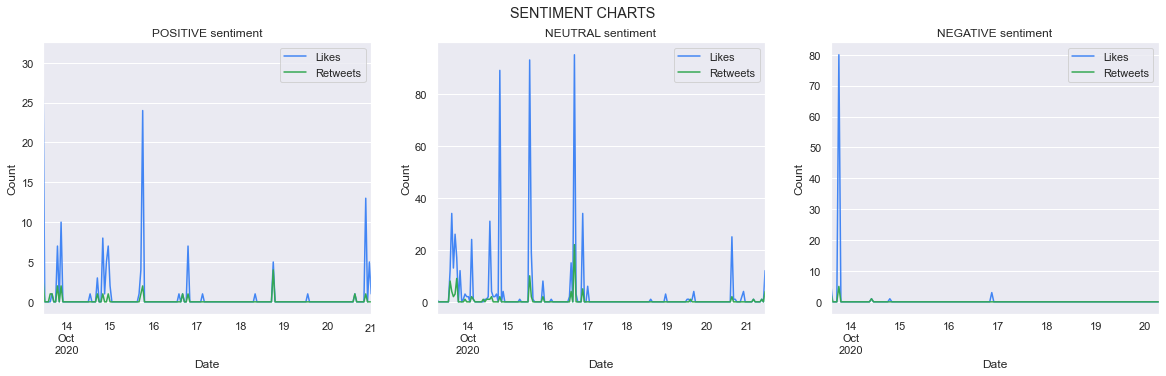

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

chart_sentiment('positive',axes[0])
chart_sentiment('neutral',axes[1])
chart_sentiment('negative',axes[2])
plt.suptitle('Sentiment charts'.upper());

## 2. Text Analysis

### 2.1 Word Analysis
Analyzing tweets at the word level. With this we aim to figure out 

1. The kind of words with a particular tweet
2. How the words are used together
3. and what makes a word 

We'll be using N-Gram to achieve this.

#### N-gram Exploration

By conducting n-gram exploration, we aim to find the commonality of words and how words are used together.

We'll first conduct an exploration with `n = 1` a.k.a __Unigram__, and then do an exploration where `n = 2` a.k.a __Bigram__

In [11]:
all_text = df['text'].str.split()
all_text = all_text.values.tolist()

corpus = [word.lower() for i in all_text for word in i]

words_in_tweets = []

for word in corpus:
    if word not in stopwords:
        words_in_tweets.append(word)

for symbol in ['-', '&']:
    for word in words_in_tweets:
        if symbol in word:
            words_in_tweets.remove(word)

In [12]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_words[0,idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

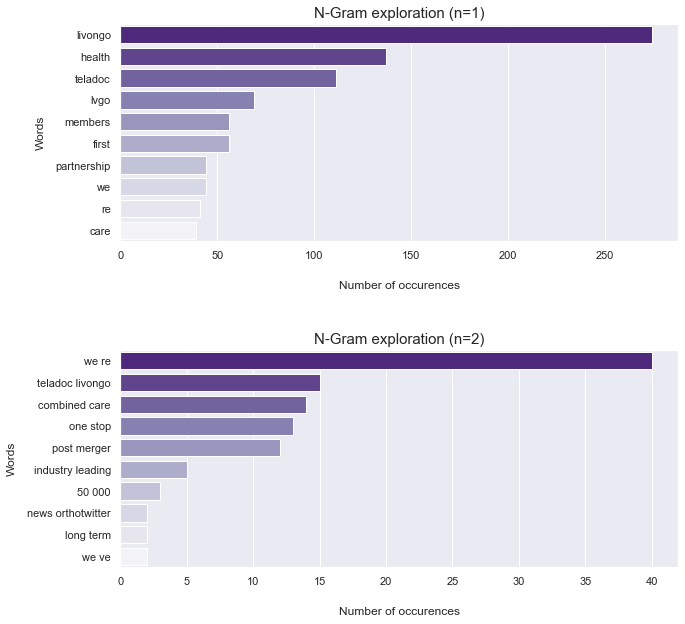

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))
axes = axes.flatten()

fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes):
    i = i + 1
    
    corpus_to_use = None
    if (i == 1):
        corpus_to_use = words_in_tweets # use words (not full corpus) for n = 1
    else:
        corpus_to_use = corpus  # Use full corpus for n > 1

    top_n_grams = get_top_ngram(corpus_to_use, i)[:30]
    x, y = map(list, zip(*top_n_grams))

    sns.barplot(x=y, y=x, orient='h', palette='Purples_r', ax=ax);
    ax.set_title(f'N-Gram exploration (n={i})', fontsize=15);
    ax.set_xlabel('Number of occurences', labelpad=20)
    ax.set_ylabel('Words', labelpad=10);

> __N.B__  We can also conduct an analysis, similar to the __Unigram__ exploration. However this is not as effective, and just shows the most common words.

In [14]:
#### Finding most common words without using n-gram


# counter = Counter(words_in_tweets)
# most = counter.most_common()

# x, y = [], []
# for word, count in most[:40]:
#     x.append(word)
#     y.append(count)
    
# fig, axes = plt.subplots(1, 1, figsize=(10,10))
# sns.barplot(x=y,y=x, ax=axes);

### 2.2 Clustering

This is grouping tweets into clusters with the aim of finding related tweets.

In [15]:
tf_idf_vec = TfidfVectorizer(stop_words='english', max_features=20000)
tf_idf = tf_idf_vec.fit_transform(df.text)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

&nbsp;

Find the optimal number of clusters to make use of.

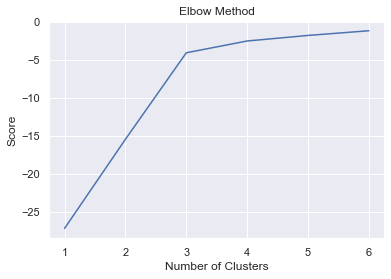

In [16]:
def determine_clusters(tf_idf_array):
    pca = PCA(n_components=2)
    y = pca.fit_transform(tf_idf_array)
    n_clusters = range(1,7)
    kmeans = [KMeans(n_clusters=i, max_iter=600) for i in n_clusters]
    
    score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
    plt.plot(n_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    
determine_clusters(tf_idf_array)

> Using **3** as the number of clusters

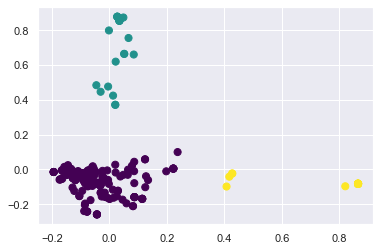

In [17]:
pca = PCA(n_components=2)
x = pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='auto')

labels = kmeans.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=50, cmap='viridis');

In [18]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(tf_idf_array, labels, 15)

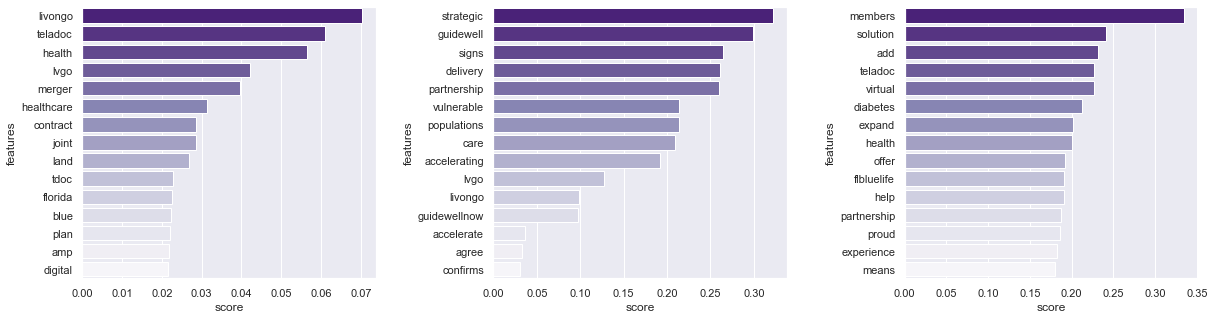

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.subplots_adjust(wspace=0.4)

sns.barplot(x='score',y='features',data=dfs[0], orient='h', ax=axes[0], palette='Purples_r')
sns.barplot(x='score',y='features',data=dfs[1], orient='h', ax=axes[1], palette='Purples_r')
sns.barplot(x='score',y='features',data=dfs[2], orient='h', ax=axes[2], palette='Purples_r');

&nbsp;
# Conclusion

More visualizations can be done using things like __WordClouds__, __Counters__, e.t.c   
However I feel this forms the basis of whatever can be done, and this can direct how tweets should be implemeneted in our application.

To Recap
We did
1. **Sentiment Analysis**   
This is useful in determining the "feeling" associated with a tweet which affects how a brand is percieved within a period of time.

2. **Text Analysis**  
This is useful in determining what those tweets say about a brand.